In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [5]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [6]:
mx = 0; root = None
for u in range(N):
    if get_size(T, [0] * N, u) > mx:
        mx = get_size(T, [0] * N, u)
        root = u
        
print(root, get_size(T, [0] * N, root), N)

744 4586 4586


In [7]:
def get_size_degree(G, V_, u, dd):
    
    I = set(get_ideal(G, V_, u))
    
    if V_[u]:
        return 0, 0
    
    V = V_.copy()
    
    s = 1; d = len([*G.predecessors(u)]) ** dd; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v in I:
                s += 1; V[v] = 1
                d += len([*G.predecessors(v)]) ** dd
                Q.append(v)
                I.remove(v)
    
    return s, d

def greedyAppDegree(G, V_, root, K, limit, dd):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        maxv = 0; u = -1
        for v in E:
            s, d = get_size_degree(G, V, v, dd)
            if d > maxv and d <= limit:
                u = v
                maxv = d
        if u == -1:
            break
        
        V, x = visit(G, V, u)
        ans.append(u); tot += maxv
        E.remove(u)
        
    return ans, tot

In [10]:
def simulate_degree(G, k, S, dd, verbose):
    
    map_prev = {}
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); D = 0
            for i in range(N):
                if not V[i]:
                    D += len([*G.predecessors(i)]) ** dd
            P = []; sP = 0
            
            if not verbose:
                print("                                                           ", end="\r")
                print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in range(N):
                if V[i]:
                    nn += 2**i
                    
            if nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R >= k:
                    low = 0; high = D
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppDegree(G, V, root, k, mid, dd)
                        if D - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppDegree(G, V, root, k, low, dd)
                    
                    if verbose:
                        print("pre low:", low, D - sP, len(P))

                    if low > 1:
                        P_, sP_ = greedyAppDegree(G, V, root, k, low - 1, dd)

                        if verbose:
                            print("low:", low, D - sP, D - sP_, len(P), len(P_))

                        if len(P_) and (abs((D - sP_) - (low - 1)) < abs((D - sP) - low) or (len(P) == 1 and sP == D)):
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppDegree(G, V, root, k, 1, dd)

                map_prev[nn] = P
    
            if verbose:
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))
                print("P: ", ' '.join([str(p) for p in P]))
#                 plot_sample_no_intersections(G, V, P, geometry, _id)

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal(G, V, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)

            if size == 1:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if size <= k:
                iters.append(t + 2)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [11]:
iters = simulate_degree(T, 5, range(N), 1, False)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 5    acc: 5.0
Result 3: 5    acc: 5.0
Result 4: 5    acc: 5.0
Result 5: 5    acc: 5.0
Result 6: 5    acc: 5.0
Result 7: 5    acc: 5.0
Result 8: 5    acc: 5.0
Result 9: 5    acc: 5.0
Result 10: 5    acc: 5.0
Result 11: 5    acc: 5.0
Result 12: 5    acc: 5.0
Result 13: 5    acc: 5.0
Result 14: 5    acc: 5.0
Result 15: 5    acc: 5.0
Result 16: 5    acc: 5.0
Result 17: 5    acc: 5.0
Result 18: 5    acc: 5.0
Result 19: 5    acc: 5.0
Result 20: 5    acc: 5.0
Result 21: 6    acc: 5.045454545454546
Result 22: 5    acc: 5.043478260869565
Result 23: 5    acc: 5.041666666666667
Result 24: 5    acc: 5.04
Result 25: 6    acc: 5.076923076923077
Result 26: 6    acc: 5.111111111111111
Result 27: 5    acc: 5.107142857142857
Result 28: 5    acc: 5.103448275862069
Result 29: 6    acc: 5.133333333333334
Result 30: 5    acc: 5.129032258064516
Result 31: 5    acc: 5.125
Result 32: 6    acc: 5.151515151515151
Result 33: 6    acc: 5.176470588235294
Res

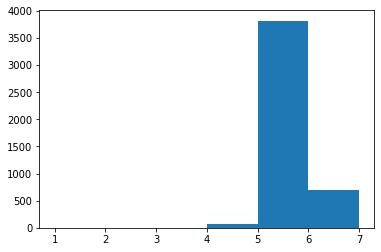

In [12]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [13]:
iters = simulate_degree(T, 5, range(N), 2, False)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 6    acc: 5.333333333333333
Result 3: 6    acc: 5.5
Result 4: 4    acc: 5.2
Result 5: 5    acc: 5.166666666666667
Result 6: 5    acc: 5.142857142857143
Result 7: 6    acc: 5.25
Result 8: 6    acc: 5.333333333333333
Result 9: 6    acc: 5.4
Result 10: 6    acc: 5.454545454545454
Result 11: 5    acc: 5.416666666666667
Result 12: 5    acc: 5.384615384615385
Result 13: 5    acc: 5.357142857142857
Result 14: 6    acc: 5.4
Result 15: 6    acc: 5.4375
Result 16: 6    acc: 5.470588235294118
Result 17: 5    acc: 5.444444444444445
Result 18: 5    acc: 5.421052631578948
Result 19: 5    acc: 5.4
Result 20: 5    acc: 5.380952380952381
Result 21: 6    acc: 5.409090909090909
Result 22: 5    acc: 5.391304347826087
Result 23: 5    acc: 5.375
Result 24: 5    acc: 5.36
Result 25: 6    acc: 5.384615384615385
Result 26: 5    acc: 5.37037037037037
Result 27: 5    acc: 5.357142857142857
Result 28: 5    acc: 5.344827586206897
Result 29: 5    acc: 5.3333

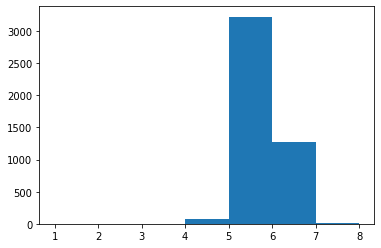

In [14]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [15]:
iters = simulate_degree(T, 5, range(N), 3, False)

Result 0: 6    acc: 6.0
Result 1: 5    acc: 5.5
Result 2: 6    acc: 5.666666666666667
Result 3: 6    acc: 5.75
Result 4: 4    acc: 5.4
Result 5: 5    acc: 5.333333333333333
Result 6: 5    acc: 5.285714285714286
Result 7: 5    acc: 5.25
Result 8: 5    acc: 5.222222222222222
Result 9: 5    acc: 5.2
Result 10: 5    acc: 5.181818181818182
Result 11: 5    acc: 5.166666666666667
Result 12: 6    acc: 5.230769230769231
Result 13: 6    acc: 5.285714285714286
Result 14: 6    acc: 5.333333333333333
Result 15: 6    acc: 5.375
Result 16: 6    acc: 5.411764705882353
Result 17: 6    acc: 5.444444444444445
Result 18: 5    acc: 5.421052631578948
Result 19: 5    acc: 5.4
Result 20: 5    acc: 5.380952380952381
Result 21: 6    acc: 5.409090909090909
Result 22: 6    acc: 5.434782608695652
Result 23: 6    acc: 5.458333333333333
Result 24: 6    acc: 5.48
Result 25: 6    acc: 5.5
Result 26: 5    acc: 5.481481481481482
Result 27: 6    acc: 5.5
Result 28: 5    acc: 5.482758620689655
Result 29: 5    acc: 5.46666

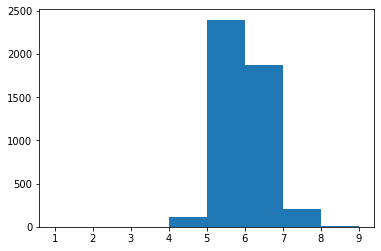

In [16]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [17]:
iters = simulate_degree(T, 5, range(N), 4, False)

Result 0: 6    acc: 6.0
Result 1: 5    acc: 5.5
Result 2: 5    acc: 5.333333333333333
Result 3: 5    acc: 5.25
Result 4: 5    acc: 5.2
Result 5: 5    acc: 5.166666666666667
Result 6: 5    acc: 5.142857142857143
Result 7: 5    acc: 5.125
Result 8: 5    acc: 5.111111111111111
Result 9: 5    acc: 5.1
Result 10: 5    acc: 5.090909090909091
Result 11: 5    acc: 5.083333333333333
Result 12: 6    acc: 5.153846153846154
Result 13: 6    acc: 5.214285714285714
Result 14: 6    acc: 5.266666666666667
Result 15: 5    acc: 5.25
Result 16: 5    acc: 5.235294117647059
Result 17: 6    acc: 5.277777777777778
Result 18: 6    acc: 5.315789473684211
Result 19: 5    acc: 5.3
Result 20: 5    acc: 5.285714285714286
Result 21: 6    acc: 5.318181818181818
Result 22: 6    acc: 5.3478260869565215
Result 23: 6    acc: 5.375
Result 24: 6    acc: 5.4
Result 25: 6    acc: 5.423076923076923
Result 26: 6    acc: 5.444444444444445
Result 27: 6    acc: 5.464285714285714
Result 28: 6    acc: 5.482758620689655
Result 29: 6

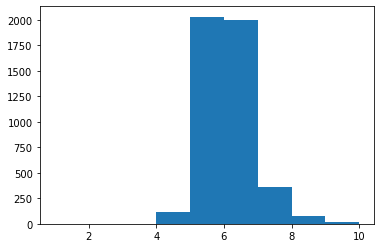

In [19]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [20]:

def greedyAppBasic(G, V_, root, K, limit):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        maxv = 0; u = -1
        for v in E:
            s = len(get_ideal(G, V, v))
            if s > maxv and s <= limit:
                u = v
                maxv = s
        if u == -1:
            break
        
        V, _ = visit(G, V, u)
        ans.append(u); tot += maxv
        E.remove(u)
        
    return ans, tot

In [21]:
def simulate_basic(G, k, S, verbose):
    
    map_prev = {}
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V)
            P = []; sP = 0
            
            if not verbose:
                print("                                                           ", end="\r")
                print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in range(N):
                if V[i]:
                    nn += 2**i
                    
            if nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R >= k:
                    low = 0; high = R
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppBasic(G, V, root, k, mid)
                        if R - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppBasic(G, V, root, k, low)
                    
                    if verbose:
                        print("pre low:", low, R - sP, len(P))

                    if low > 1:
                        P_, sP_ = greedyAppBasic(G, V, root, k, low - 1)

                        if verbose:
                            print("low:", low, R - sP, R - sP_, len(P), len(P_))

                        if len(P_) and (abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R)):
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppBasic(G, V, root, k, 1)

                map_prev[nn] = P
    
            if verbose:
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))
                print("P: ", ' '.join([str(p) for p in P]))
#                 plot_sample_no_intersections(G, V, P, geometry, _id)

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal(G, V, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)

            if size == 1:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if size <= k:
                iters.append(t + 2)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [22]:
iters = simulate_basic(T, 5, range(N), False)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 5    acc: 5.0
Result 3: 5    acc: 5.0
Result 4: 5    acc: 5.0
Result 5: 5    acc: 5.0
Result 6: 5    acc: 5.0
Result 7: 5    acc: 5.0
Result 8: 5    acc: 5.0
Result 9: 5    acc: 5.0
Result 10: 5    acc: 5.0
Result 11: 5    acc: 5.0
Result 12: 5    acc: 5.0
Result 13: 5    acc: 5.0
Result 14: 5    acc: 5.0
Result 15: 5    acc: 5.0
Result 16: 5    acc: 5.0
Result 17: 5    acc: 5.0
Result 18: 5    acc: 5.0
Result 19: 5    acc: 5.0
Result 20: 5    acc: 5.0
Result 21: 5    acc: 5.0
Result 22: 5    acc: 5.0
Result 23: 5    acc: 5.0
Result 24: 5    acc: 5.0
Result 25: 5    acc: 5.0
Result 26: 5    acc: 5.0
Result 27: 5    acc: 5.0
Result 28: 5    acc: 5.0
Result 29: 5    acc: 5.0
Result 30: 5    acc: 5.0
Result 31: 5    acc: 5.0
Result 32: 5    acc: 5.0
Result 33: 5    acc: 5.0
Result 34: 5    acc: 5.0
Result 35: 5    acc: 5.0
Result 36: 5    acc: 5.0
Result 37: 5    acc: 5.0
Result 38: 5    acc: 5.0
Result 39: 5    acc: 5.0
Result 40:

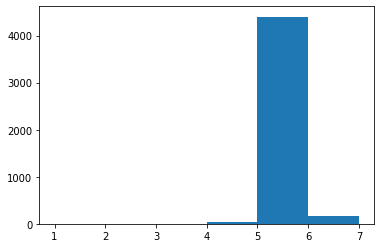

In [23]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()